# MLSSのoptimal advertising problem demoを再現

Original is http://nbviewer.ipython.org/github/cvxgrp/cvx_short_course/blob/master/applications/optimal_advertising.ipynb

- m advertisers/ads, $i = 1, ... , m$
- n time slots, $t = 1, ... ,n$
- $T_t$ is total traffic in time slot $t$
- $D_{it} \geq 0$ is number of ad $i$ displayed in period $t$
- $\sum_i D_{it} \leq T_t$
- contracted minimum total displays: $\sum_t D_{it} \leq c_i$
- goal: choose $D_{it}$

Boyd先生のデモを読み解いて手元で動かす。  
クリックが発生する度に広告毎に設定された収益が発生する、広告予算等の制約の元で収益を最大化する問題。

## シミュレーション用のデータ作成

In [7]:
np.random.seed(2)
m = 5 # Number of Ads
n = 24 # 24 hours

### Traffic

In [8]:
SCALE = 10000
T = np.sin(np.linspace(-2*np.pi/2,2*np.pi  -2*np.pi/2,n)) * SCALE
T += -np.min(T) + SCALE

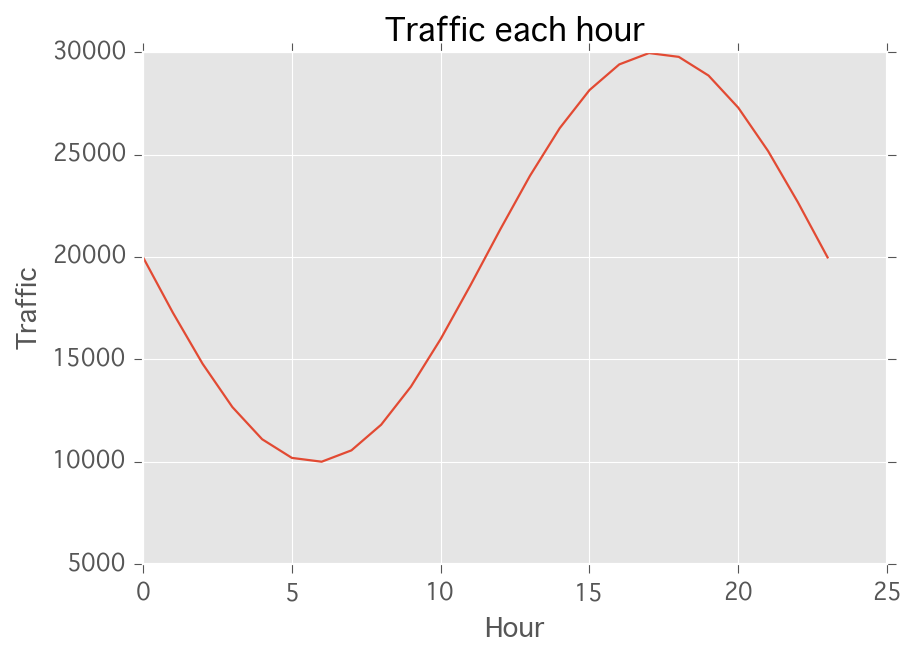

In [9]:
plt.plot(T)
plt.xlabel('Hour')
plt.ylabel("Traffic")
plt.title('Traffic each hour')

### CTR

時間毎にCTRが変わるという設定らしい

In [10]:
# Adの平均CTRと時間毎の偏りを一様分布から作って時間毎のCTRを生成
P_ad = np.random.uniform(size=(m,1))
P_time = np.random.uniform(size=(1,n))
P = P_ad.dot(P_time)

In [11]:
print('CTR for each ads and hour')
df = pd.DataFrame.from_records(P.T)
df.index.name = 'Hour'
df.columns = list('ABCDE')
df.head(10)

CTR for each ads and hour


,A,B,C,D,E
Hour,,,,,
0,0.144024,0.008564,0.181573,0.143802,0.138862
1,0.089226,0.005306,0.112488,0.089088,0.086028
2,0.269999,0.016055,0.340390,0.269583,0.260322
3,0.130648,0.007769,0.164709,0.130446,0.125965
4,0.116335,0.006918,0.146665,0.116156,0.112166
5,0.270811,0.016104,0.341414,0.270393,0.261105
6,0.230703,0.013719,0.290850,0.230347,0.222434
7,0.058676,0.003489,0.073974,0.058586,0.056573
8,0.223917,0.013315,0.282295,0.223572,0.215892


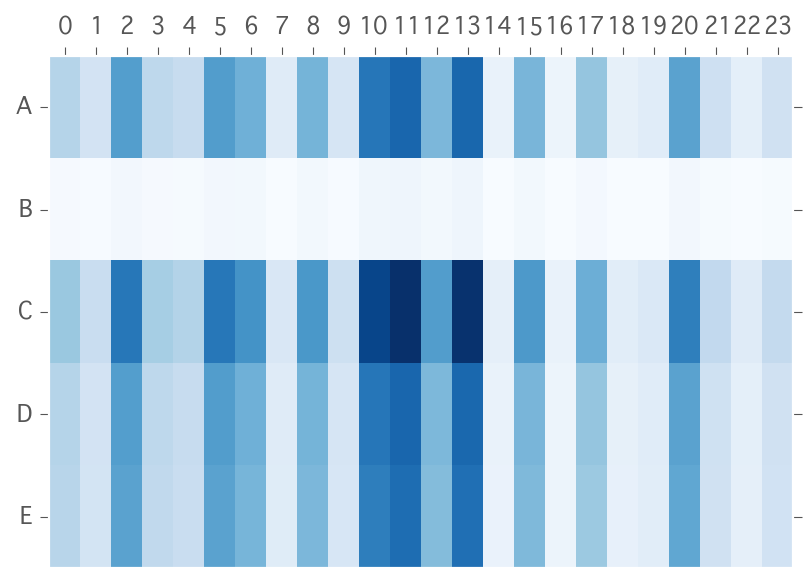

In [12]:
column_labels = range(0,24)
row_labels = list('ABCDE')
fig, ax = plt.subplots()
heatmap = ax.pcolor(P, cmap=plt.cm.Blues)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(P.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(P.shape[0])+0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False)
ax.set_yticklabels(row_labels, minor=False)
ax.set_xlim(0, 24)
plt.show()

## 制約

- 広告毎の予算
- 広告毎の最低配信数

In [13]:
# 予算
B = np.random.lognormal(mean=8, size=(m, 1)) + 10000
B = 1000*np.round(B/1000)

In [14]:
# 最低配信数
c = np.random.uniform(size=(m,1))
c *= 0.6*T.sum()/c.sum()
c = 1000*np.round(c/1000)

In [15]:
# CPC
R = np.array([np.random.lognormal(c.min()/c[i]) for i in range(m)])

In [16]:
df = pd.DataFrame(index = list('ABCDE'))
df['Budget'] = B
df['Contracted Minimum total displays'] = c
df['Cost Per Click'] = R

In [17]:
df

,Budget,Contracted Minimum total displays,Cost Per Click
A,12000,42000,0.046736
B,10000,87000,1.229867
C,15000,64000,2.278694
D,11000,18000,1.986733
E,19000,77000,2.731301


## cvxpyで解く

In [18]:
from cvxpy import Variable, Problem, Maximize, min_elemwise

求めるのはAdの時間毎の配信数 $D_{it}$

In [19]:
D = Variable(m, n) 

Ad毎の消化金額 $S_i = min(CPC_i * CTR_{it} * D_{it},  Budget_i)$

In [20]:
Si = [min_elemwise(R[i]*P[i,:]*D[i,:].T, B[i]) for i in range(m)]

$\displaystyle \sum_i{S_i}$ を最大化する$D_{it}$を求める。$S_i$はAffineとMinの組みあわせなのでconvexと言える。

In [21]:
prob = Problem(Maximize(sum(Si)), [
               D >= 0,              # 配信数はゼロ以上
               D.T*np.ones(m) <= T, # 各時間の配信数は各時間のトラフィック以下
               D*np.ones(n) >= c    # 各広告の配信数は最低配信数以上
              ])
prob.solve()

49178.805179336625

## Results

$D_{it}$

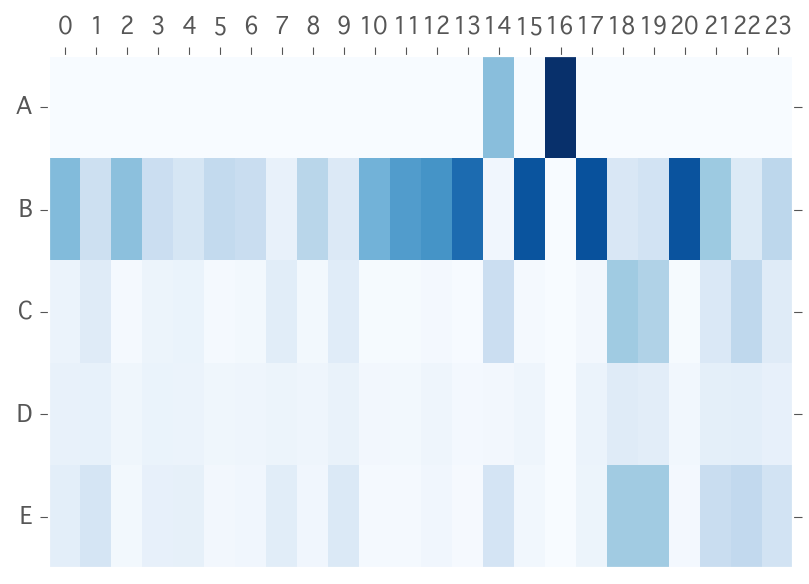

In [22]:
fig, ax = plt.subplots()
data = D.value.A
heatmap = ax.pcolor(data, cmap=plt.cm.Blues)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(P.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(P.shape[0])+0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False)
ax.set_yticklabels(row_labels, minor=False)
ax.set_xlim(0, 24)
plt.show()

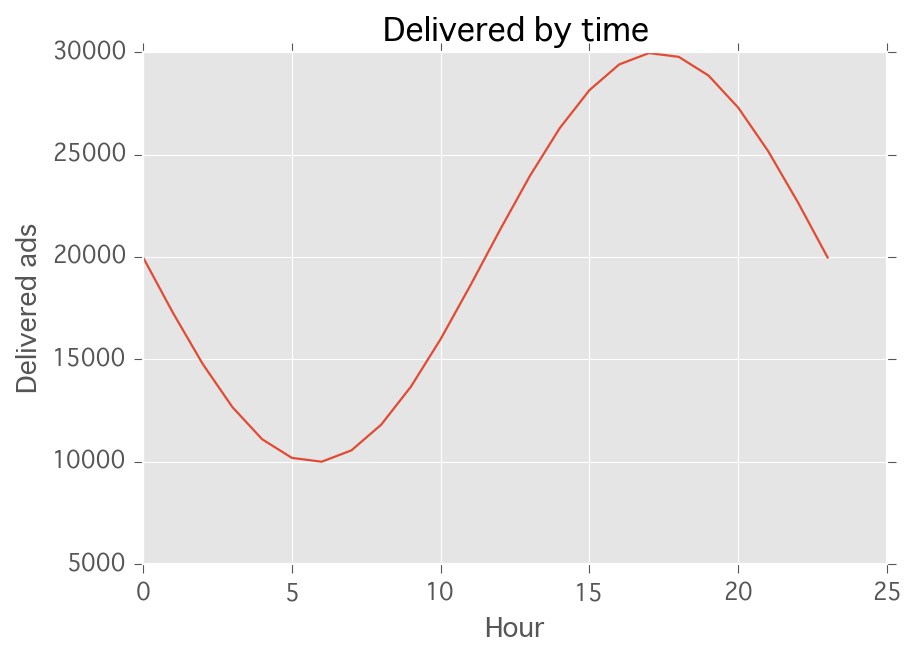

In [23]:
plt.plot(data.sum(axis=0))
plt.title('Delivered by time')
plt.xlabel('Hour')
plt.ylabel('Delivered ads')

In [24]:
df = pd.DataFrame(index = list('ABCDE'))
df['Contracted Minimum total displays'] = c
df['Delivered'] = np.sum(data, axis=1).astype(int)
df['Click'] = np.sum(data * P, axis=1).astype(int)
df['CPC'] = R
df['Spend'] = (np.sum(data * P, axis=1).astype(int) * R).astype(int)
df['Budget'] = B
df['Rest of Budget'] = df['Budget'] - df['Spend']
df

,Contracted Minimum total displays,Delivered,Click,CPC,Spend,Budget,Rest of Budget
A,42000,42000,1274,0.046736,59,12000,11941
B,87000,255486,3349,1.229867,4118,10000,5882
C,64000,64003,6582,2.278694,14998,15000,2
D,18000,40773,5536,1.986733,10998,11000,2
E,77000,77176,6956,2.731301,18998,19000,2


単価の高い広告は予算消化まで配信できている、Aは安すぎるので配信されなかった模様